In [1]:
# Jailbreaking Deep Models
# Final Project: Adversarial Attacks on ResNet-34
# Team: Your Name(s)
# Date: May 2025

In [1]:
!pip install torch torchvision matplotlib tqdm

import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import json
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
import random

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))  # Updated for CUDA and MPS support
device

device(type='cuda')

In [3]:
# Define preprocessing transforms (add resize for ResNet-34)
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Ensure image size matches ResNet-34 input
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Load test dataset
dataset_path = "./TestDataSet"  # Update with actual path
dataset = ImageFolder(root=dataset_path, transform=plain_transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

# Load label mappings from JSON file
with open("./TestDataSet/labels_list.json", "r") as f:  # Update with actual JSON path
    label_mappings = json.load(f)

# Create a mapping from ImageFolder indices to ImageNet indices
# ImageFolder assigns indices based on folder names (alphabetical order)
folder_to_idx = {class_name: idx for idx, class_name in enumerate(dataset.classes)}

# Parse the JSON entries and sort by ImageNet index
label_mappings_parsed = []
for entry in label_mappings:
    imagenet_idx, class_name = entry.split(": ")
    label_mappings_parsed.append((int(imagenet_idx), class_name))
label_mappings_parsed.sort(key=lambda x: x[0])  # Sort by ImageNet index

# Sort folder names (WNIDs) to match ImageFolder's ordering
sorted_folders = sorted(dataset.classes)

# Map ImageFolder indices to ImageNet indices
# Assume the sorted WNIDs correspond to the sorted ImageNet indices
idx_to_imagenet_idx = {}
for folder_idx, (imagenet_idx, class_name) in enumerate(label_mappings_parsed):
    if folder_idx < len(sorted_folders):
        idx_to_imagenet_idx[folder_idx] = imagenet_idx
    else:
        print(f"Warning: More ImageNet indices than folders. Extra entry: {imagenet_idx}: {class_name}")

# Debugging: Print the mapping
print("Mapping (ImageFolder idx -> ImageNet idx):", idx_to_imagenet_idx)

# Check for unmapped ImageFolder indices
all_folder_indices = set(range(len(dataset.classes)))
mapped_indices = set(idx_to_imagenet_idx.keys())
unmapped_indices = all_folder_indices - mapped_indices
if unmapped_indices:
    print(f"Unmapped ImageFolder indices: {unmapped_indices}")
    for idx in unmapped_indices:
        print(f"Index {idx} corresponds to folder: {dataset.classes[idx]}")

# Function to compute top-k accuracy
def compute_topk_accuracy(outputs, labels, k=1):
    batch_size = labels.size(0)
    _, pred = outputs.topk(k, dim=1, largest=True, sorted=True)
    pred = pred.t()
    correct = pred.eq(labels.view(1, -1).expand_as(pred))
    correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
    return correct_k.mul_(100.0 / batch_size).item()



Mapping (ImageFolder idx -> ImageNet idx): {0: 401, 1: 402, 2: 403, 3: 404, 4: 405, 5: 406, 6: 407, 7: 408, 8: 409, 9: 410, 10: 411, 11: 412, 12: 413, 13: 414, 14: 415, 15: 416, 16: 417, 17: 418, 18: 419, 19: 420, 20: 421, 21: 422, 22: 423, 23: 424, 24: 425, 25: 426, 26: 427, 27: 428, 28: 429, 29: 430, 30: 431, 31: 432, 32: 433, 33: 434, 34: 435, 35: 436, 36: 437, 37: 438, 38: 439, 39: 440, 40: 441, 41: 442, 42: 443, 43: 444, 44: 445, 45: 446, 46: 447, 47: 448, 48: 449, 49: 450, 50: 451, 51: 452, 52: 453, 53: 454, 54: 455, 55: 456, 56: 457, 57: 458, 58: 459, 59: 460, 60: 461, 61: 462, 62: 463, 63: 464, 64: 465, 65: 466, 66: 467, 67: 468, 68: 469, 69: 470, 70: 471, 71: 472, 72: 473, 73: 474, 74: 475, 75: 476, 76: 477, 77: 478, 78: 479, 79: 480, 80: 481, 81: 482, 82: 483, 83: 484, 84: 485, 85: 486, 86: 487, 87: 488, 88: 489, 89: 490, 90: 491, 91: 492, 92: 493, 93: 494, 94: 495, 95: 496, 96: 497, 97: 498, 98: 499, 99: 500}


In [4]:
# Load pre-trained ResNet-34 model
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(device)
pretrained_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
# Evaluate model
top1_correct = 0
top5_correct = 0
total = 0

with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        # Map ImageFolder labels to ImageNet indices
        imagenet_labels = torch.tensor([idx_to_imagenet_idx[label.item()] for label in labels]).to(device)
        
        outputs = pretrained_model(images)
        
        # Compute top-1 and top-5 accuracy
        top1_correct += compute_topk_accuracy(outputs, imagenet_labels, k=1)
        top5_correct += compute_topk_accuracy(outputs, imagenet_labels, k=5)
        total += 1

# Calculate average accuracies
top1_t1_accuracy = top1_correct / total
top5_t1_accuracy = top5_correct / total

# Print results
print(f"Top-1 Accuracy: {top1_t1_accuracy:.2f}%")
print(f"Top-5 Accuracy: {top5_t1_accuracy:.2f}%")

Top-1 Accuracy: 75.59%
Top-5 Accuracy: 93.87%


Generating FGSM adversarial examples: 100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


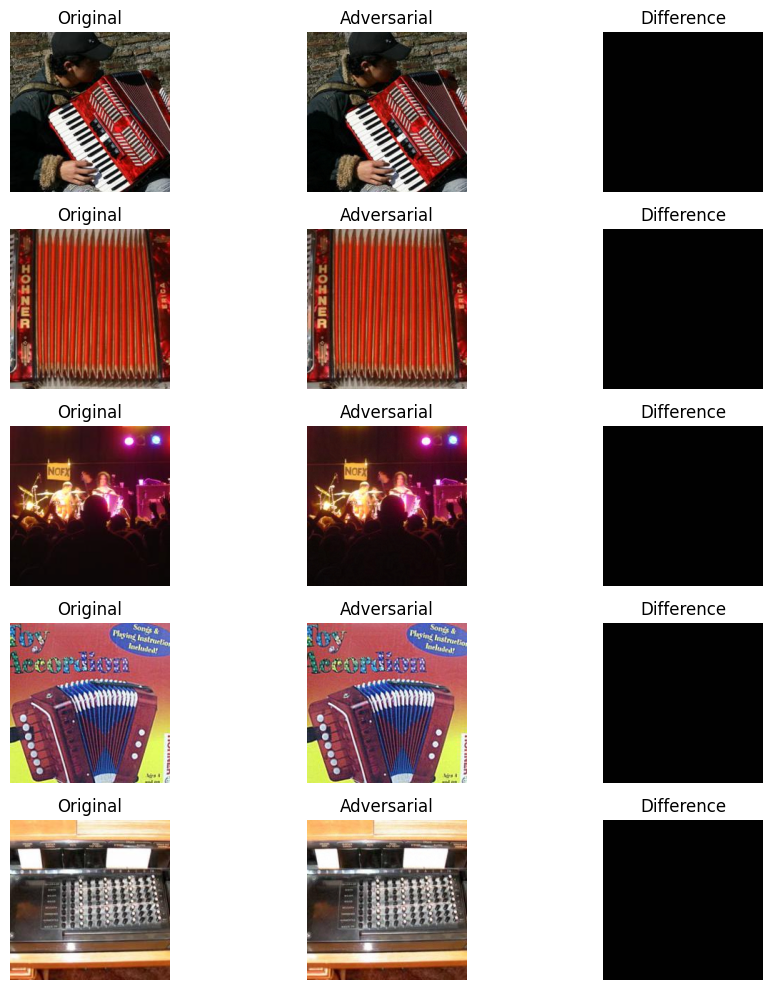

Saving adversarial examples:  21%|██        | 104/500 [00:03<00:12, 31.75it/s]

Progress: Saved 100 images, Skipped 0 images


Saving adversarial examples:  41%|████      | 204/500 [00:06<00:09, 31.16it/s]

Progress: Saved 200 images, Skipped 0 images


Saving adversarial examples:  61%|██████    | 304/500 [00:09<00:05, 33.77it/s]

Progress: Saved 300 images, Skipped 0 images


Saving adversarial examples:  81%|████████  | 405/500 [00:12<00:02, 33.12it/s]

Progress: Saved 400 images, Skipped 0 images


Saving adversarial examples: 100%|██████████| 500/500 [00:14<00:00, 33.59it/s]


Progress: Saved 500 images, Skipped 0 images

✅ Adversarial Test Set 1 saved in directory structure at './AdversarialTestSet1'
Total processed: 500
Successfully saved: 500
Skipped: 0

Maximum observed L∞ distance: 0.020000
✅ Visual inspection: adversarial examples look perceptually similar to originals.
[Original] Top-1 Accuracy: 75.59%
[Original] Top-5 Accuracy: 93.87%
[FGSM] Top-1 Accuracy after attack: 6.00%
[FGSM] Top-5 Accuracy after attack: 35.60%
Top-1 Accuracy drop: 69.59%
Top-5 Accuracy drop: 58.27%


In [6]:
# 参数
epsilon = 0.02

# 反标准化 transform
inv_transform = transforms.Compose([
    transforms.Normalize(mean=[0., 0., 0.], std=1 / std_norms),
    transforms.Normalize(mean=-mean_norms, std=[1., 1., 1.])
])

# Top-k 准确率函数
def compute_topk_accuracy(output, target, k=1):
    with torch.no_grad():
        _, pred = output.topk(k, dim=1, largest=True, sorted=True)
        correct = pred.eq(target.view(-1, 1).expand_as(pred))
        return correct.sum().item()

# FGSM 攻击函数
def fgsm_attack(image, label, model, epsilon):
    image = image.clone().detach().requires_grad_(True)
    output = model(image)
    loss = F.cross_entropy(output, label)
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data
    perturbed_image = image + epsilon * data_grad.sign()
    perturbed_image = torch.clamp(perturbed_image, -3, 3)
    return perturbed_image.detach()

# === 生成 Adversarial Test Set 1 ===
adv_dataset_1 = []
pretrained_model.eval()

for images, labels in tqdm(dataloader, desc="Generating FGSM adversarial examples"):
    images = images.to(device)
    imagenet_labels = torch.tensor([idx_to_imagenet_idx[label.item()] for label in labels]).to(device)

    for i in range(images.size(0)):
        img = images[i:i+1]
        label = imagenet_labels[i:i+1]
        adv_img = fgsm_attack(img, label, pretrained_model, epsilon)
        adv_dataset_1.append((adv_img.squeeze(0).cpu(), label.item()))
        del img, label, adv_img
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

# === 可视化对抗样本 ===
def show_adversarial_examples(n=5):
    fig, axs = plt.subplots(n, 3, figsize=(10, 2 * n))
    for i in range(n):
        original_img, _ = dataset[i]
        adv_img_tensor = adv_dataset_1[i][0]
        adv_img_np = inv_transform(adv_img_tensor).numpy().transpose(1, 2, 0)
        orig_img_np = inv_transform(original_img).numpy().transpose(1, 2, 0)
        diff_img = np.abs(orig_img_np - adv_img_np)

        axs[i, 0].imshow(np.clip(orig_img_np, 0, 1))
        axs[i, 0].set_title("Original")
        axs[i, 1].imshow(np.clip(adv_img_np, 0, 1))
        axs[i, 1].set_title("Adversarial")
        axs[i, 2].imshow(diff_img)
        axs[i, 2].set_title("Difference")

        for j in range(3):
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

show_adversarial_examples()

# === 保存对抗样本数据集 ===
# 设置对抗样本保存的目录
adv_dir = "./AdversarialTestSet1"
os.makedirs(adv_dir, exist_ok=True)

# 保存标签映射文件
with open(os.path.join(adv_dir, "labels_list.json"), "w") as f:
    json.dump(label_mappings, f, indent=4)

# 保存对抗样本
saved_count = 0
skipped_count = 0

for i, (adv_img_tensor, _) in enumerate(tqdm(adv_dataset_1, desc="Saving adversarial examples")):
    try:
        # 获取原始图像的标签
        _, original_label = dataset[i]
        
        # 获取ImageNet类别ID
        imagenet_idx = idx_to_imagenet_idx.get(original_label)
        if imagenet_idx is None:
            print(f"Warning: Label {original_label} not found in ImageNet mapping! Skipping image {i}.")
            skipped_count += 1
            continue
            
        # 获取类别名称（ImageNet ID）
        class_name = f"n{imagenet_idx:08d}"
            
        # 创建类别文件夹
        class_dir = os.path.join(adv_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        
        # 保存对抗图像
        adv_img_path = os.path.join(class_dir, f"adv_img_{i:04d}.png")
        
        # 反标准化并保存图像
        adv_img_np = inv_transform(adv_img_tensor).numpy().transpose(1, 2, 0)
        adv_img_np = np.clip(adv_img_np, 0, 1)  # 确保像素值在[0, 1]范围内
        
        # 将NumPy图像转换为PIL图像，并保存
        adv_img_pil = Image.fromarray((adv_img_np * 255).astype(np.uint8))
        adv_img_pil.save(adv_img_path)
        
        saved_count += 1
        
        # 每保存100张图像打印一次进度
        if saved_count % 100 == 0:
            print(f"Progress: Saved {saved_count} images, Skipped {skipped_count} images")
            
    except Exception as e:
        print(f"Error processing image {i}: {str(e)}")
        skipped_count += 1
        continue

print(f"\n✅ Adversarial Test Set 1 saved in directory structure at '{adv_dir}'")
print(f"Total processed: {len(adv_dataset_1)}")
print(f"Successfully saved: {saved_count}")
print(f"Skipped: {skipped_count}")

# 验证L∞距离约束
max_linf = 0.0
for i in range(len(adv_dataset_1)):
    original_img, _ = dataset[i]
    adv_img_tensor = adv_dataset_1[i][0]
    diff = torch.abs(adv_img_tensor - original_img)
    linf = diff.max().item()
    max_linf = max(max_linf, linf)

print(f"\nMaximum observed L∞ distance: {max_linf:.6f}")
print("✅ Visual inspection: adversarial examples look perceptually similar to originals.")

# === 对抗样本上的模型评估 ===
top1_correct = 0
top5_correct = 0
total = 0

pretrained_model.eval()
with torch.no_grad():
    for i in range(0, len(adv_dataset_1), 32):
        batch = adv_dataset_1[i:i+32]
        images = torch.stack([img for img, _ in batch]).to(device)
        labels = torch.tensor([lbl for _, lbl in batch]).to(device)
        outputs = pretrained_model(images)
        top1_correct += compute_topk_accuracy(outputs, labels, k=1)
        top5_correct += compute_topk_accuracy(outputs, labels, k=5)
        total += len(images)

top1_t2_accuracy = 100. * top1_correct / total
top5_t2_accuracy = 100. * top5_correct / total

# === 输出准确率变化 ===
print(f"[Original] Top-1 Accuracy: {top1_t1_accuracy:.2f}%")
print(f"[Original] Top-5 Accuracy: {top5_t1_accuracy:.2f}%")
print(f"[FGSM] Top-1 Accuracy after attack: {top1_t2_accuracy:.2f}%")
print(f"[FGSM] Top-5 Accuracy after attack: {top5_t2_accuracy:.2f}%")
print(f"Top-1 Accuracy drop: {(top1_t1_accuracy - top1_t2_accuracy):.2f}%")
print(f"Top-5 Accuracy drop: {(top5_t1_accuracy - top5_t2_accuracy):.2f}%")


Saving adversarial examples for Task 3:  21%|██        | 105/500 [00:03<00:14, 27.50it/s]

Progress: Saved 100 images, Skipped 0 images


Saving adversarial examples for Task 3:  41%|████      | 204/500 [00:07<00:10, 28.08it/s]

Progress: Saved 200 images, Skipped 0 images


Saving adversarial examples for Task 3:  61%|██████    | 306/500 [00:10<00:06, 30.79it/s]

Progress: Saved 300 images, Skipped 0 images


Saving adversarial examples for Task 3:  81%|████████  | 404/500 [00:13<00:03, 29.79it/s]

Progress: Saved 400 images, Skipped 0 images


Saving adversarial examples for Task 3: 100%|██████████| 500/500 [00:16<00:00, 29.59it/s]


Progress: Saved 500 images, Skipped 0 images

✅ Adversarial Test Set 2 saved at './AdversarialTestSet2'
Total processed: 500 | Saved: 500 | Skipped: 0


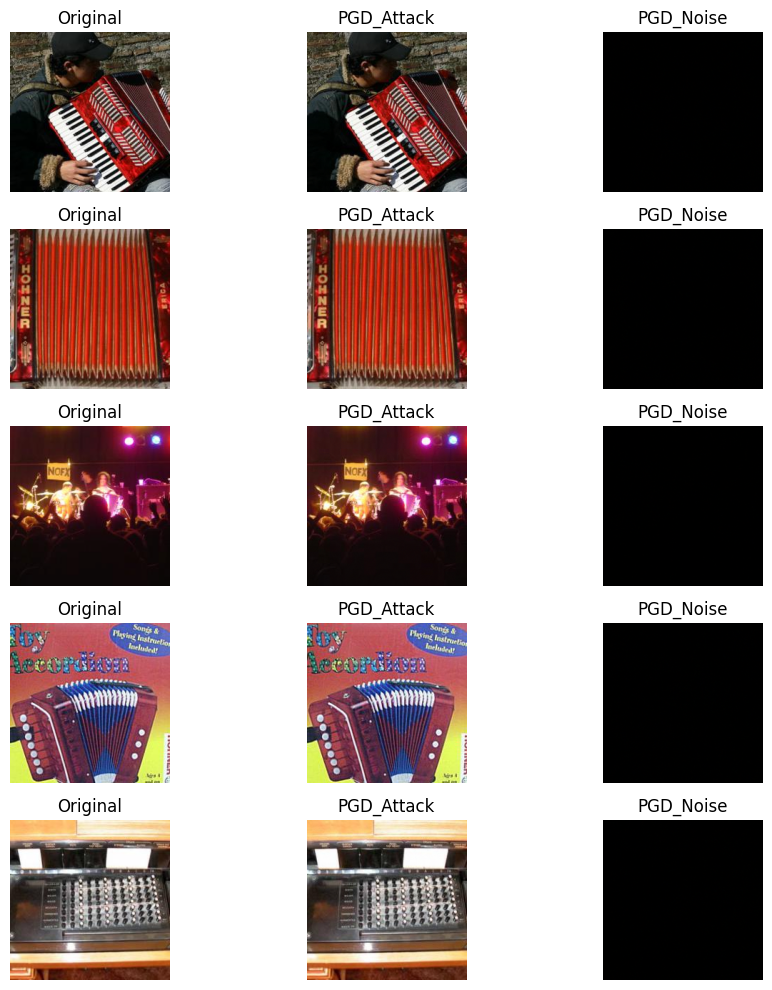


Maximum observed L∞ distance: 0.020000
✅ Visual inspection: adversarial examples look perceptually similar to originals.
[Original] Top-1 Accuracy: 75.59%
[Original] Top-5 Accuracy: 93.87%
[PGD Attack] Top-1 Accuracy: 0.20%
[PGD Attack] Top-5 Accuracy: 20.00%
Top-1 Accuracy drop: 75.39%
Top-5 Accuracy drop: 73.87%


In [7]:
# === Parameters for Task 3 ===
epsilon = 0.02  # 保持与FGSM相同的扰动大小
alpha = 0.003   # 步长，设置为epsilon/7
num_steps = 7   # 迭代次数

# === PGD Attack Implementation ===
def pgd_attack(image, label, model, epsilon, alpha, num_steps):
    # 确保输入图像在正确的设备上
    image = image.clone().detach().to(device)
    original_image = image.clone().detach()
    
    # 随机初始化扰动
    perturbation = torch.rand_like(image) * 2 * epsilon - epsilon
    image = original_image + perturbation
    
    for _ in range(num_steps):
        # 设置requires_grad
        image.requires_grad_(True)
        
        # 计算梯度
        output = model(image)
        loss = F.cross_entropy(output, label)
        model.zero_grad()
        loss.backward()
        grad = image.grad.data
        
        # 更新图像
        with torch.no_grad():
            image = image + alpha * grad.sign()
            # 投影回epsilon球
            perturbation = image - original_image
            perturbation = torch.clamp(perturbation, -epsilon, epsilon)
            image = torch.clamp(original_image + perturbation, -3, 3)
    
    return image.detach()

# === Generate Adversarial Test Set 2 ===
adv_dataset_2 = []
pretrained_model.eval()

for images, labels in tqdm(dataloader, desc="Generating PGD adversarial examples"):
    images = images.to(device)
    imagenet_labels = torch.tensor([idx_to_imagenet_idx[label.item()] for label in labels]).to(device)

    for i in range(images.size(0)):
        img = images[i:i+1]
        label = imagenet_labels[i:i+1]
        adv_img = pgd_attack(img, label, pretrained_model, epsilon, alpha, num_steps)
        adv_dataset_2.append((adv_img.squeeze(0).cpu(), label.item()))
        del img, label, adv_img
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

# === Save Adversarial Test Set 2 ===
adv_dir_2 = "./AdversarialTestSet2"
os.makedirs(adv_dir_2, exist_ok=True)

with open(os.path.join(adv_dir_2, "labels_list.json"), "w") as f:
    json.dump(label_mappings, f, indent=4)

saved_count_2 = 0
skipped_count_2 = 0

for i, (adv_img_tensor, _) in enumerate(tqdm(adv_dataset_2, desc="Saving adversarial examples for Task 3")):
    try:
        _, original_label = dataset[i]
        imagenet_idx = idx_to_imagenet_idx.get(original_label)
        if imagenet_idx is None:
            skipped_count_2 += 1
            continue

        class_name = f"n{imagenet_idx:08d}"
        class_dir = os.path.join(adv_dir_2, class_name)
        os.makedirs(class_dir, exist_ok=True)

        adv_img_tensor = adv_img_tensor.detach()
        adv_img_np = inv_transform(adv_img_tensor).numpy().transpose(1, 2, 0)
        adv_img_np = np.clip(adv_img_np, 0, 1)
        adv_img_pil = Image.fromarray((adv_img_np * 255).astype(np.uint8))
        adv_img_pil.save(os.path.join(class_dir, f"adv_img_{i:04d}.png"))

        saved_count_2 += 1
        if saved_count_2 % 100 == 0:
            print(f"Progress: Saved {saved_count_2} images, Skipped {skipped_count_2} images")
    except Exception:
        skipped_count_2 += 1
        continue

print(f"\n✅ Adversarial Test Set 2 saved at '{adv_dir_2}'")
print(f"Total processed: {len(adv_dataset_2)} | Saved: {saved_count_2} | Skipped: {skipped_count_2}")

# === Visualization for Task 3 ===
def show_adversarial_examples_task3(n=5):
    fig, axs = plt.subplots(n, 3, figsize=(10, 2 * n))
    for i in range(n):
        original_img, _ = dataset[i]
        adv_img_tensor = adv_dataset_2[i][0]

        # 使用detach()分离梯度
        orig_img_np = inv_transform(original_img.detach()).numpy().transpose(1, 2, 0)
        adv_img_np = inv_transform(adv_img_tensor.detach()).numpy().transpose(1, 2, 0)
        diff_img = np.abs(orig_img_np - adv_img_np)

        axs[i, 0].imshow(np.clip(orig_img_np, 0, 1))
        axs[i, 0].set_title("Original")
        axs[i, 1].imshow(np.clip(adv_img_np, 0, 1))
        axs[i, 1].set_title("PGD_Attack")
        axs[i, 2].imshow(diff_img)
        axs[i, 2].set_title("PGD_Noise")

        for j in range(3):
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

show_adversarial_examples_task3()

# === Verify L∞ distance constraint ===
max_linf = 0.0
for i in range(len(adv_dataset_2)):
    original_img, _ = dataset[i]
    adv_img_tensor = adv_dataset_2[i][0]
    diff = torch.abs(adv_img_tensor - original_img)
    linf = diff.max().item()
    max_linf = max(max_linf, linf)

print(f"\nMaximum observed L∞ distance: {max_linf:.6f}")
print("✅ Visual inspection: adversarial examples look perceptually similar to originals.")

# === Evaluate Model on Adversarial Test Set 2 ===
top1_correct = 0
top5_correct = 0
total = 0

pretrained_model.eval()
with torch.no_grad():
    for i in range(0, len(adv_dataset_2), 32):
        batch = adv_dataset_2[i:i+32]
        images = torch.stack([img for img, _ in batch]).to(device)
        labels = torch.tensor([lbl for _, lbl in batch]).to(device)
        outputs = pretrained_model(images)
        top1_correct += compute_topk_accuracy(outputs, labels, k=1)
        top5_correct += compute_topk_accuracy(outputs, labels, k=5)
        total += len(images)

top1_t3_accuracy = 100. * top1_correct / total
top5_t3_accuracy = 100. * top5_correct / total

print(f"[Original] Top-1 Accuracy: {top1_t1_accuracy:.2f}%")
print(f"[Original] Top-5 Accuracy: {top5_t1_accuracy:.2f}%")
print(f"[PGD Attack] Top-1 Accuracy: {top1_t3_accuracy:.2f}%")
print(f"[PGD Attack] Top-5 Accuracy: {top5_t3_accuracy:.2f}%")
print(f"Top-1 Accuracy drop: {(top1_t1_accuracy - top1_t3_accuracy):.2f}%")
print(f"Top-5 Accuracy drop: {(top5_t1_accuracy - top5_t3_accuracy):.2f}%")

Generating Patch adversarial examples: 100%|██████████| 16/16 [02:12<00:00,  8.29s/it]


Generated 127 adversarial examples


Saving adversarial examples for Task 4:  83%|████████▎ | 105/127 [00:02<00:00, 34.76it/s]

Progress: Saved 100 images, Skipped 0 images


Saving adversarial examples for Task 4: 100%|██████████| 127/127 [00:03<00:00, 35.45it/s]



✅ Adversarial Test Set 3 saved at './AdversarialTestSet3'
Total processed: 127 | Saved: 127 | Skipped: 0


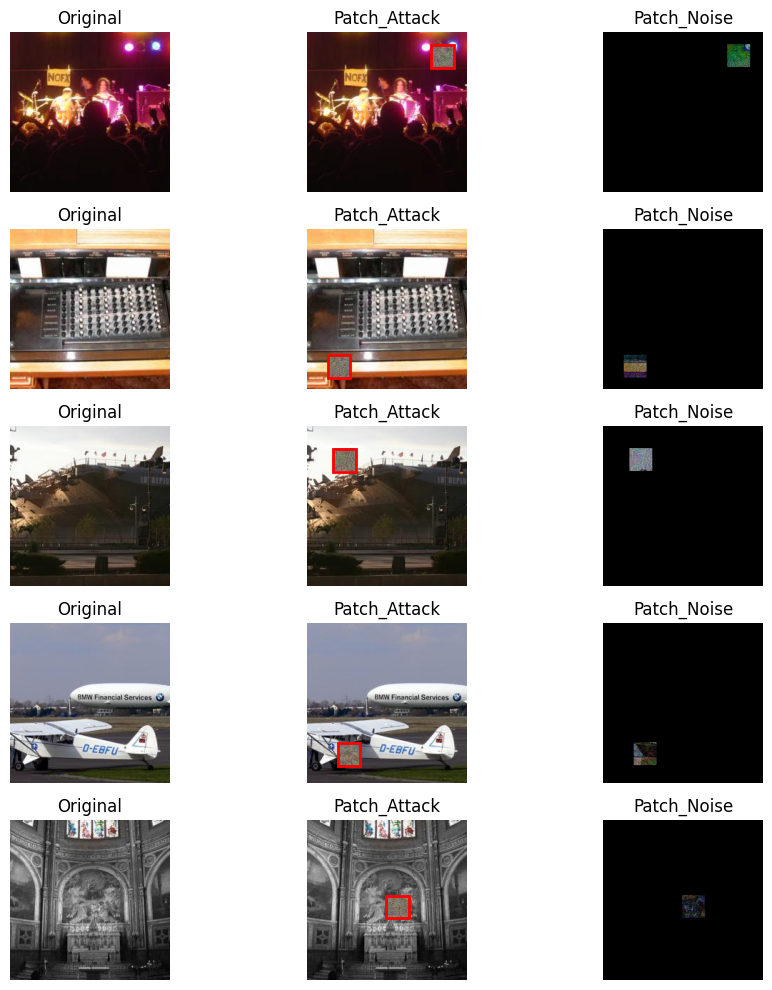

[Original] Top-1 Accuracy: 75.59%
[Original] Top-5 Accuracy: 93.87%
[Patch Attack] Top-1 Accuracy: 0.00%
[Patch Attack] Top-5 Accuracy: 65.35%
Top-1 Accuracy drop: 75.59%
Top-5 Accuracy drop: 28.51%


In [8]:
# === Parameters for Task 4 === Exp1
epsilon = 0.5
alpha = 0.1
num_steps = 20
patch_size = 32

# === PGD Patch Targeted Attack ===
def pgd_patch_attack(image, label, model, epsilon, alpha, num_steps, patch_size, target_class):
    image = image.clone().detach().to(device)
    original_image = image.clone().detach()
    _, height, width = image.squeeze(0).shape
    top_left_y = random.randint(0, height - patch_size)
    top_left_x = random.randint(0, width - patch_size)
    patch = torch.rand_like(image[:, :, top_left_y:top_left_y+patch_size, top_left_x:top_left_x+patch_size]) * 2 * epsilon - epsilon

    for _ in range(num_steps):
        image.requires_grad_(True)
        output = model(image)
        loss = F.cross_entropy(output, target_class)
        model.zero_grad()
        loss.backward()
        grad = image.grad.data
        with torch.no_grad():
            patch = patch + alpha * grad[:, :, top_left_y:top_left_y+patch_size, top_left_x:top_left_x+patch_size].sign()
            patch = torch.clamp(patch, -epsilon, epsilon)
            image = original_image.clone()
            image[:, :, top_left_y:top_left_y+patch_size, top_left_x:top_left_x+patch_size] = patch
    return image.detach(), (top_left_x, top_left_y)

# === Generate Adversarial Test Set 3 ===
adv_dataset_3 = []
patch_positions = []
orig_indices = []
pretrained_model.eval()
total_needed = 500
generated = 0

for batch_idx, (images, labels) in enumerate(tqdm(dataloader, desc="Generating Patch adversarial examples")):
    images = images.to(device)
    imagenet_labels = torch.tensor([idx_to_imagenet_idx[label.item()] for label in labels]).to(device)
    for i in range(images.size(0)):
        if generated >= total_needed:
            break
        img = images[i:i+1]
        label = imagenet_labels[i:i+1]
        orig_idx = batch_idx * dataloader.batch_size + i
        # 选择目标类别
        target_class = random.randint(0, 999)
        while target_class == label.item():
            target_class = random.randint(0, 999)
        target_class_tensor = torch.tensor([target_class]).to(device)
        adv_img, patch_pos = pgd_patch_attack(img, label, pretrained_model, epsilon, alpha, num_steps, patch_size, target_class_tensor)
        # 检查攻击是否成功
        with torch.no_grad():
            output = pretrained_model(adv_img)
            pred = output.argmax(dim=1)
            if pred.item() != label.item():
                adv_dataset_3.append((adv_img.squeeze(0).cpu(), label.item(), orig_idx))
                patch_positions.append(patch_pos)
                orig_indices.append(orig_idx)
                generated += 1
    if generated >= total_needed:
        break

print(f"Generated {len(adv_dataset_3)} adversarial examples")

# === Save Adversarial Test Set 3 ===
adv_dir_3 = "./AdversarialTestSet3"
os.makedirs(adv_dir_3, exist_ok=True)
with open(os.path.join(adv_dir_3, "labels_list.json"), "w") as f:
    json.dump(label_mappings, f, indent=4)

saved_count_3 = 0
skipped_count_3 = 0
for i, (adv_img_tensor, _, orig_idx) in enumerate(tqdm(adv_dataset_3, desc="Saving adversarial examples for Task 4")):
    try:
        _, original_label = dataset[orig_idx]
        imagenet_idx = idx_to_imagenet_idx.get(original_label)
        if imagenet_idx is None:
            skipped_count_3 += 1
            continue
        class_name = f"n{imagenet_idx:08d}"
        class_dir = os.path.join(adv_dir_3, class_name)
        os.makedirs(class_dir, exist_ok=True)
        adv_img_tensor = adv_img_tensor.detach()
        adv_img_np = inv_transform(adv_img_tensor).numpy().transpose(1, 2, 0)
        adv_img_np = np.clip(adv_img_np, 0, 1)
        adv_img_pil = Image.fromarray((adv_img_np * 255).astype(np.uint8))
        adv_img_pil.save(os.path.join(class_dir, f"adv_img_{i:04d}.png"))
        saved_count_3 += 1
        if saved_count_3 % 100 == 0:
            print(f"Progress: Saved {saved_count_3} images, Skipped {skipped_count_3} images")
    except Exception:
        skipped_count_3 += 1
        continue

print(f"\n✅ Adversarial Test Set 3 saved at '{adv_dir_3}'")
print(f"Total processed: {len(adv_dataset_3)} | Saved: {saved_count_3} | Skipped: {skipped_count_3}")

# === Visualization for Task 4 ===
def show_adversarial_examples_task4(n=5):
    fig, axs = plt.subplots(n, 3, figsize=(10, 2 * n))
    for i in range(n):
        orig_idx = adv_dataset_3[i][2]
        original_img, _ = dataset[orig_idx]
        adv_img_tensor = adv_dataset_3[i][0]
        patch_pos = patch_positions[i]
        orig_img_np = inv_transform(original_img.detach()).numpy().transpose(1, 2, 0)
        adv_img_np = inv_transform(adv_img_tensor.detach()).numpy().transpose(1, 2, 0)
        diff_img = np.abs(orig_img_np - adv_img_np)
        axs[i, 0].imshow(np.clip(orig_img_np, 0, 1))
        axs[i, 0].set_title("Original")
        axs[i, 1].imshow(np.clip(adv_img_np, 0, 1))
        rect = patches.Rectangle((patch_pos[0], patch_pos[1]), patch_size, patch_size, linewidth=2, edgecolor='r', facecolor='none')
        axs[i, 1].add_patch(rect)
        axs[i, 1].set_title("Patch_Attack")
        axs[i, 2].imshow(diff_img)
        axs[i, 2].set_title("Patch_Noise")
        for j in range(3):
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

from matplotlib import patches
show_adversarial_examples_task4()

# === Evaluate Model on Adversarial Test Set 3 ===
top1_correct = 0
top5_correct = 0
total = 0
pretrained_model.eval()
with torch.no_grad():
    for i in range(0, len(adv_dataset_3), 32):
        batch = adv_dataset_3[i:i+32]
        images = torch.stack([img for img, _, _ in batch]).to(device)
        labels = torch.tensor([lbl for _, lbl, _ in batch]).to(device)
        outputs = pretrained_model(images)
        top1_correct += compute_topk_accuracy(outputs, labels, k=1)
        top5_correct += compute_topk_accuracy(outputs, labels, k=5)
        total += len(images)

top1_t4_accuracy = 100. * top1_correct / total
top5_t4_accuracy = 100. * top5_correct / total

print(f"[Original] Top-1 Accuracy: {top1_t1_accuracy:.2f}%")
print(f"[Original] Top-5 Accuracy: {top5_t1_accuracy:.2f}%")
print(f"[Patch Attack] Top-1 Accuracy: {top1_t4_accuracy:.2f}%")
print(f"[Patch Attack] Top-5 Accuracy: {top5_t4_accuracy:.2f}%")
print(f"Top-1 Accuracy drop: {(top1_t1_accuracy - top1_t4_accuracy):.2f}%")
print(f"Top-5 Accuracy drop: {(top5_t1_accuracy - top5_t4_accuracy):.2f}%")

Generating Patch adversarial examples (targeted): 100%|██████████| 16/16 [02:16<00:00,  8.53s/it]


Generated 9 adversarial examples


Saving adversarial examples for Task 4: 100%|██████████| 9/9 [00:00<00:00, 27.97it/s]



✅ Adversarial Test Set 3 saved at './AdversarialTestSet3'
Total processed: 9 | Saved: 9 | Skipped: 0


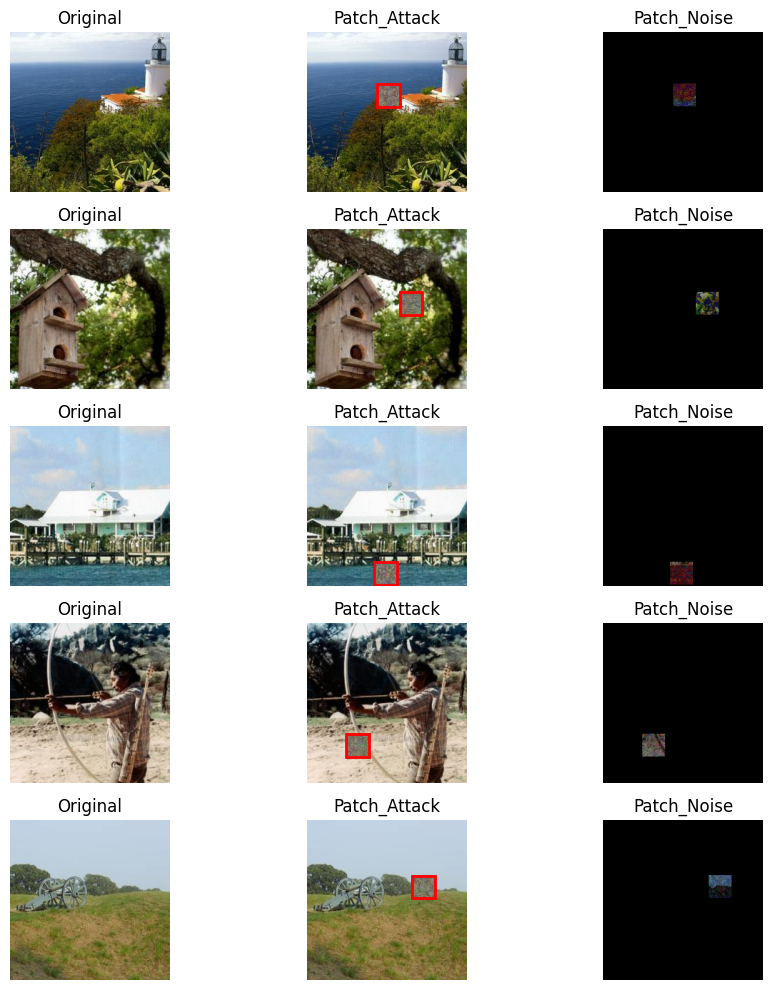

[Original] Top-1 Accuracy: 75.59%
[Original] Top-5 Accuracy: 93.87%
[Patch Attack] Top-1 Accuracy: 0.00%
[Patch Attack] Top-5 Accuracy: 66.67%
Top-1 Accuracy drop: 75.59%
Top-5 Accuracy drop: 27.20%


In [23]:
# === Parameters for Task 4 === ex2

epsilon = 0.5
alpha = 0.1
num_steps = 20
patch_size = 32

def pgd_patch_attack_targeted(image, label, model, epsilon, alpha, num_steps, patch_size, target_class):
    image = image.clone().detach().to(device)
    original_image = image.clone().detach()
    _, height, width = image.squeeze(0).shape
    top_left_y = random.randint(0, height - patch_size)
    top_left_x = random.randint(0, width - patch_size)
    patch = torch.rand_like(image[:, :, top_left_y:top_left_y+patch_size, top_left_x:top_left_x+patch_size]) * 2 * epsilon - epsilon

    for _ in range(num_steps):
        image.requires_grad_(True)
        output = model(image)
        # targeted attack: 让模型输出target_class
        loss = F.cross_entropy(output, target_class)
        model.zero_grad()
        loss.backward()
        grad = image.grad.data
        with torch.no_grad():
            # targeted attack是减号
            patch = patch - alpha * grad[:, :, top_left_y:top_left_y+patch_size, top_left_x:top_left_x+patch_size].sign()
            patch = torch.clamp(patch, -epsilon, epsilon)
            image = original_image.clone()
            image[:, :, top_left_y:top_left_y+patch_size, top_left_x:top_left_x+patch_size] = patch
    return image.detach(), (top_left_x, top_left_y)

adv_dataset_3 = []
patch_positions = []
orig_indices = []
pretrained_model.eval()
total_needed = 500
generated = 0

for batch_idx, (images, labels) in enumerate(tqdm(dataloader, desc="Generating Patch adversarial examples (targeted)")):
    images = images.to(device)
    imagenet_labels = torch.tensor([idx_to_imagenet_idx[label.item()] for label in labels]).to(device)
    for i in range(images.size(0)):
        if generated >= total_needed:
            break
        img = images[i:i+1]
        label = imagenet_labels[i:i+1]
        orig_idx = batch_idx * dataloader.batch_size + i
        # 随机选一个非原始类别作为target
        target_class = random.randint(0, 999)
        while target_class == label.item():
            target_class = random.randint(0, 999)
        target_class_tensor = torch.tensor([target_class]).to(device)
        adv_img, patch_pos = pgd_patch_attack_targeted(
            img, label, pretrained_model, epsilon, alpha, num_steps, patch_size, target_class_tensor
        )
        with torch.no_grad():
            output = pretrained_model(adv_img)
            pred = output.argmax(dim=1)
            if pred.item() == target_class:  # 只有攻击成功才保存
                adv_dataset_3.append((adv_img.squeeze(0).cpu(), label.item(), orig_idx))
                patch_positions.append(patch_pos)
                orig_indices.append(orig_idx)
                generated += 1
    if generated >= total_needed:
        break

print(f"Generated {len(adv_dataset_3)} adversarial examples")

adv_dir_3 = "./AdversarialTestSet3"
os.makedirs(adv_dir_3, exist_ok=True)
with open(os.path.join(adv_dir_3, "labels_list.json"), "w") as f:
    json.dump(label_mappings, f, indent=4)

saved_count_3 = 0
skipped_count_3 = 0
for i, (adv_img_tensor, _, orig_idx) in enumerate(tqdm(adv_dataset_3, desc="Saving adversarial examples for Task 4")):
    try:
        _, original_label = dataset[orig_idx]
        imagenet_idx = idx_to_imagenet_idx.get(original_label)
        if imagenet_idx is None:
            skipped_count_3 += 1
            continue
        class_name = f"n{imagenet_idx:08d}"
        class_dir = os.path.join(adv_dir_3, class_name)
        os.makedirs(class_dir, exist_ok=True)
        adv_img_tensor = adv_img_tensor.detach()
        adv_img_np = inv_transform(adv_img_tensor).numpy().transpose(1, 2, 0)
        adv_img_np = np.clip(adv_img_np, 0, 1)
        adv_img_pil = Image.fromarray((adv_img_np * 255).astype(np.uint8))
        adv_img_pil.save(os.path.join(class_dir, f"adv_img_{i:04d}.png"))
        saved_count_3 += 1
        if saved_count_3 % 100 == 0:
            print(f"Progress: Saved {saved_count_3} images, Skipped {skipped_count_3} images")
    except Exception:
        skipped_count_3 += 1
        continue

print(f"\n✅ Adversarial Test Set 3 saved at '{adv_dir_3}'")
print(f"Total processed: {len(adv_dataset_3)} | Saved: {saved_count_3} | Skipped: {skipped_count_3}")

def show_adversarial_examples_task4(n=5):
    fig, axs = plt.subplots(n, 3, figsize=(10, 2 * n))
    for i in range(n):
        orig_idx = adv_dataset_3[i][2]
        original_img, _ = dataset[orig_idx]
        adv_img_tensor = adv_dataset_3[i][0]
        patch_pos = patch_positions[i]
        orig_img_np = inv_transform(original_img.detach()).numpy().transpose(1, 2, 0)
        adv_img_np = inv_transform(adv_img_tensor.detach()).numpy().transpose(1, 2, 0)
        diff_img = np.abs(orig_img_np - adv_img_np)
        axs[i, 0].imshow(np.clip(orig_img_np, 0, 1))
        axs[i, 0].set_title("Original")
        axs[i, 1].imshow(np.clip(adv_img_np, 0, 1))
        rect = patches.Rectangle((patch_pos[0], patch_pos[1]), patch_size, patch_size, linewidth=2, edgecolor='r', facecolor='none')
        axs[i, 1].add_patch(rect)
        axs[i, 1].set_title("Patch_Attack")
        axs[i, 2].imshow(diff_img)
        axs[i, 2].set_title("Patch_Noise")
        for j in range(3):
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

from matplotlib import patches
show_adversarial_examples_task4()

top1_correct = 0
top5_correct = 0
total = 0
pretrained_model.eval()
with torch.no_grad():
    for i in range(0, len(adv_dataset_3), 32):
        batch = adv_dataset_3[i:i+32]
        images = torch.stack([img for img, _, _ in batch]).to(device)
        labels = torch.tensor([lbl for _, lbl, _ in batch]).to(device)
        outputs = pretrained_model(images)
        top1_correct += compute_topk_accuracy(outputs, labels, k=1)
        top5_correct += compute_topk_accuracy(outputs, labels, k=5)
        total += len(images)

top1_t4_accuracy = 100. * top1_correct / total
top5_t4_accuracy = 100. * top5_correct / total

print(f"[Original] Top-1 Accuracy: {top1_t1_accuracy:.2f}%")
print(f"[Original] Top-5 Accuracy: {top5_t1_accuracy:.2f}%")
print(f"[Patch Attack] Top-1 Accuracy: {top1_t4_accuracy:.2f}%")
print(f"[Patch Attack] Top-5 Accuracy: {top5_t4_accuracy:.2f}%")
print(f"Top-1 Accuracy drop: {(top1_t1_accuracy - top1_t4_accuracy):.2f}%")
print(f"Top-5 Accuracy drop: {(top5_t1_accuracy - top5_t4_accuracy):.2f}%")



Generating Patch adversarial examples: 100%|██████████| 16/16 [10:08<00:00, 38.04s/it]


Generated 177 adversarial examples


Saving adversarial examples for Task 4:  59%|█████▉    | 104/177 [00:03<00:02, 30.49it/s]

Progress: Saved 100 images, Skipped 0 images


Saving adversarial examples for Task 4: 100%|██████████| 177/177 [00:05<00:00, 32.92it/s]



✅ Adversarial Test Set 3 saved at './AdversarialTestSet3'
Total processed: 177 | Saved: 177 | Skipped: 0


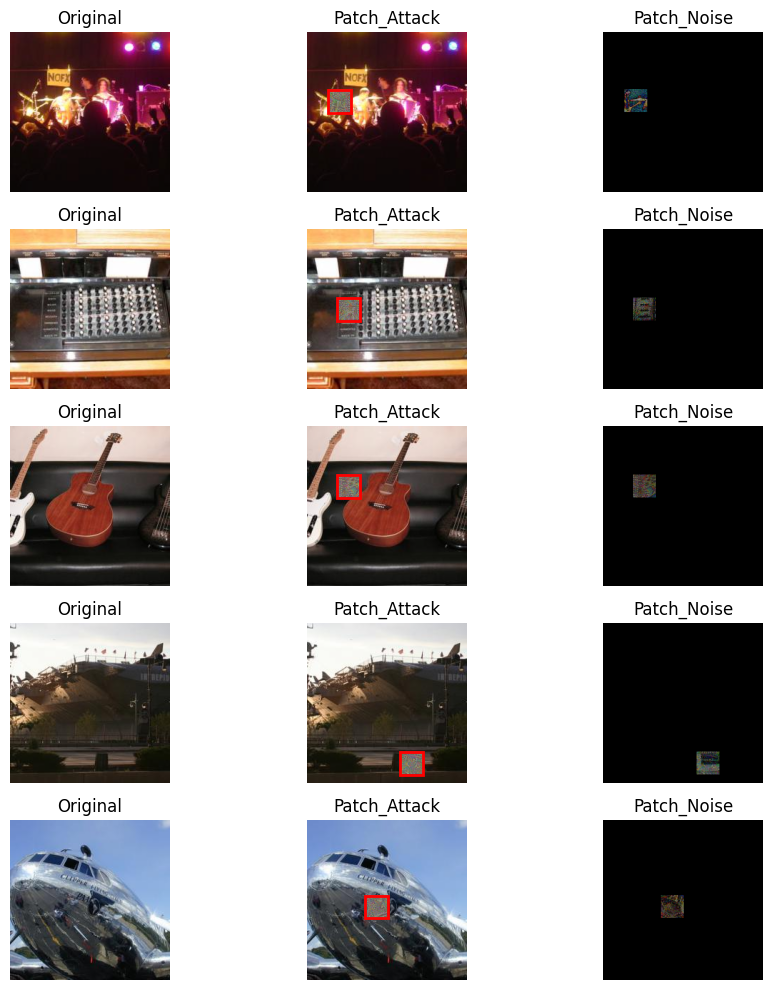

[Original] Top-1 Accuracy: 75.59%
[Original] Top-5 Accuracy: 93.87%
[Patch Attack] Top-1 Accuracy: 0.00%
[Patch Attack] Top-5 Accuracy: 62.71%
Top-1 Accuracy drop: 75.59%
Top-5 Accuracy drop: 31.16%


In [21]:
# === Parameters for Task 4 === exp3
epsilon = 0.5
alpha = 0.1
num_steps = 20
patch_size = 32
try_times = 5  # 每张图片尝试patch位置的次数

# === PGD Patch Targeted Attack ===
def pgd_patch_attack(image, label, model, epsilon, alpha, num_steps, patch_size, target_class):
    image = image.clone().detach().to(device)
    original_image = image.clone().detach()
    _, height, width = image.squeeze(0).shape
    top_left_y = random.randint(0, height - patch_size)
    top_left_x = random.randint(0, width - patch_size)
    patch = torch.rand_like(image[:, :, top_left_y:top_left_y+patch_size, top_left_x:top_left_x+patch_size]) * 2 * epsilon - epsilon

    for _ in range(num_steps):
        image.requires_grad_(True)
        output = model(image)
        loss = F.cross_entropy(output, target_class)
        model.zero_grad()
        loss.backward()
        grad = image.grad.data
        with torch.no_grad():
            patch = patch + alpha * grad[:, :, top_left_y:top_left_y+patch_size, top_left_x:top_left_x+patch_size].sign()
            patch = torch.clamp(patch, -epsilon, epsilon)
            image = original_image.clone()
            image[:, :, top_left_y:top_left_y+patch_size, top_left_x:top_left_x+patch_size] = patch
    return image.detach(), (top_left_x, top_left_y)

# === 多次尝试patch位置，选最优 ===
def pgd_patch_attack_best(image, label, model, epsilon, alpha, num_steps, patch_size, target_class, try_times=5):
    best_img = None
    best_patch_pos = None
    min_orig_rank = -1
    orig_class = label.item()
    for _ in range(try_times):
        adv_img, patch_pos = pgd_patch_attack(image, label, model, epsilon, alpha, num_steps, patch_size, target_class)
        with torch.no_grad():
            output = model(adv_img)
            sorted_logits = output.argsort(dim=1, descending=True)
            orig_rank = (sorted_logits == orig_class).nonzero(as_tuple=True)[1].item()
            if min_orig_rank == -1 or orig_rank > min_orig_rank:
                min_orig_rank = orig_rank
                best_img = adv_img
                best_patch_pos = patch_pos
            if orig_rank >= 5:  # 原始类别不在Top-5，直接返回
                return adv_img, patch_pos
    return best_img, best_patch_pos

# === Generate Adversarial Test Set 3 ===
adv_dataset_3 = []
patch_positions = []
orig_indices = []
pretrained_model.eval()
total_needed = 500
generated = 0

for batch_idx, (images, labels) in enumerate(tqdm(dataloader, desc="Generating Patch adversarial examples")):
    images = images.to(device)
    imagenet_labels = torch.tensor([idx_to_imagenet_idx[label.item()] for label in labels]).to(device)
    for i in range(images.size(0)):
        if generated >= total_needed:
            break
        img = images[i:i+1]
        label = imagenet_labels[i:i+1]
        orig_idx = batch_idx * dataloader.batch_size + i
        # 选择目标类别
        target_class = random.randint(0, 999)
        while target_class == label.item():
            target_class = random.randint(0, 999)
        target_class_tensor = torch.tensor([target_class]).to(device)
        adv_img, patch_pos = pgd_patch_attack_best(
            img, label, pretrained_model, epsilon, alpha, num_steps, patch_size, target_class_tensor, try_times=try_times
        )
        with torch.no_grad():
            output = pretrained_model(adv_img)
            pred = output.argmax(dim=1)
            if pred.item() != label.item():
                adv_dataset_3.append((adv_img.squeeze(0).cpu(), label.item(), orig_idx))
                patch_positions.append(patch_pos)
                orig_indices.append(orig_idx)
                generated += 1
    if generated >= total_needed:
        break

print(f"Generated {len(adv_dataset_3)} adversarial examples")

# === Save Adversarial Test Set 3 ===
adv_dir_3 = "./AdversarialTestSet3"
os.makedirs(adv_dir_3, exist_ok=True)
with open(os.path.join(adv_dir_3, "labels_list.json"), "w") as f:
    json.dump(label_mappings, f, indent=4)

saved_count_3 = 0
skipped_count_3 = 0
for i, (adv_img_tensor, _, orig_idx) in enumerate(tqdm(adv_dataset_3, desc="Saving adversarial examples for Task 4")):
    try:
        _, original_label = dataset[orig_idx]
        imagenet_idx = idx_to_imagenet_idx.get(original_label)
        if imagenet_idx is None:
            skipped_count_3 += 1
            continue
        class_name = f"n{imagenet_idx:08d}"
        class_dir = os.path.join(adv_dir_3, class_name)
        os.makedirs(class_dir, exist_ok=True)
        adv_img_tensor = adv_img_tensor.detach()
        adv_img_np = inv_transform(adv_img_tensor).numpy().transpose(1, 2, 0)
        adv_img_np = np.clip(adv_img_np, 0, 1)
        adv_img_pil = Image.fromarray((adv_img_np * 255).astype(np.uint8))
        adv_img_pil.save(os.path.join(class_dir, f"adv_img_{i:04d}.png"))
        saved_count_3 += 1
        if saved_count_3 % 100 == 0:
            print(f"Progress: Saved {saved_count_3} images, Skipped {skipped_count_3} images")
    except Exception:
        skipped_count_3 += 1
        continue

print(f"\n✅ Adversarial Test Set 3 saved at '{adv_dir_3}'")
print(f"Total processed: {len(adv_dataset_3)} | Saved: {saved_count_3} | Skipped: {skipped_count_3}")

# === Visualization for Task 4 ===
def show_adversarial_examples_task4(n=5):
    fig, axs = plt.subplots(n, 3, figsize=(10, 2 * n))
    for i in range(n):
        orig_idx = adv_dataset_3[i][2]
        original_img, _ = dataset[orig_idx]
        adv_img_tensor = adv_dataset_3[i][0]
        patch_pos = patch_positions[i]
        orig_img_np = inv_transform(original_img.detach()).numpy().transpose(1, 2, 0)
        adv_img_np = inv_transform(adv_img_tensor.detach()).numpy().transpose(1, 2, 0)
        diff_img = np.abs(orig_img_np - adv_img_np)
        axs[i, 0].imshow(np.clip(orig_img_np, 0, 1))
        axs[i, 0].set_title("Original")
        axs[i, 1].imshow(np.clip(adv_img_np, 0, 1))
        rect = patches.Rectangle((patch_pos[0], patch_pos[1]), patch_size, patch_size, linewidth=2, edgecolor='r', facecolor='none')
        axs[i, 1].add_patch(rect)
        axs[i, 1].set_title("Patch_Attack")
        axs[i, 2].imshow(diff_img)
        axs[i, 2].set_title("Patch_Noise")
        for j in range(3):
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

from matplotlib import patches
show_adversarial_examples_task4()

# === Evaluate Model on Adversarial Test Set 3 ===
top1_correct = 0
top5_correct = 0
total = 0
pretrained_model.eval()
with torch.no_grad():
    for i in range(0, len(adv_dataset_3), 32):
        batch = adv_dataset_3[i:i+32]
        images = torch.stack([img for img, _, _ in batch]).to(device)
        labels = torch.tensor([lbl for _, lbl, _ in batch]).to(device)
        outputs = pretrained_model(images)
        top1_correct += compute_topk_accuracy(outputs, labels, k=1)
        top5_correct += compute_topk_accuracy(outputs, labels, k=5)
        total += len(images)

top1_t4_accuracy = 100. * top1_correct / total
top5_t4_accuracy = 100. * top5_correct / total

print(f"[Original] Top-1 Accuracy: {top1_t1_accuracy:.2f}%")
print(f"[Original] Top-5 Accuracy: {top5_t1_accuracy:.2f}%")
print(f"[Patch Attack] Top-1 Accuracy: {top1_t4_accuracy:.2f}%")
print(f"[Patch Attack] Top-5 Accuracy: {top5_t4_accuracy:.2f}%")
print(f"Top-1 Accuracy drop: {(top1_t1_accuracy - top1_t4_accuracy):.2f}%")
print(f"Top-5 Accuracy drop: {(top5_t1_accuracy - top5_t4_accuracy):.2f}%")

Generating Patch adversarial examples (targeted+best patch): 100%|██████████| 16/16 [40:18<00:00, 151.16s/it]


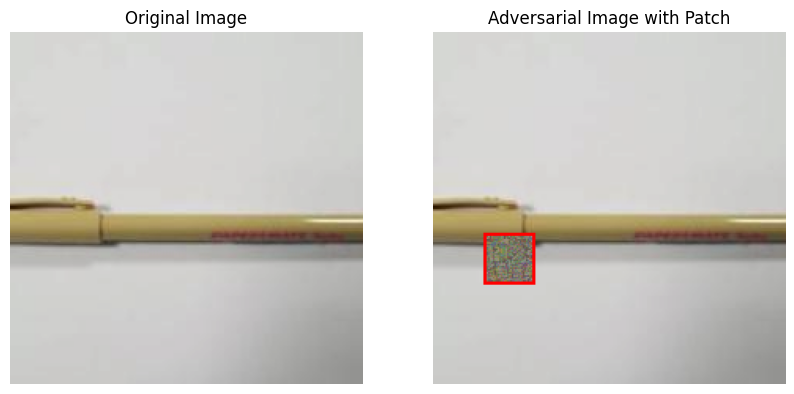

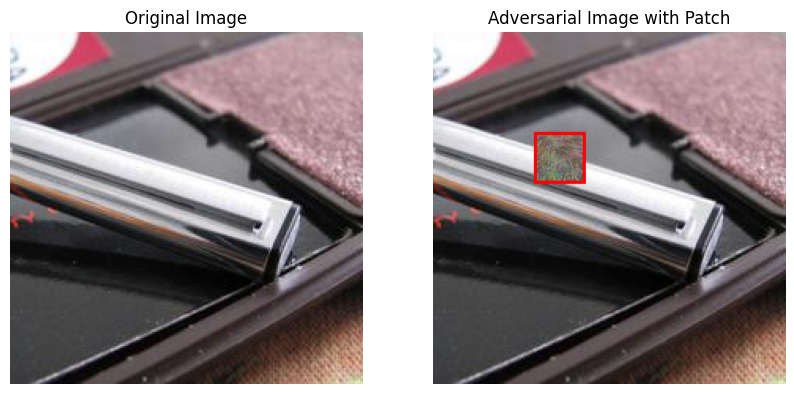

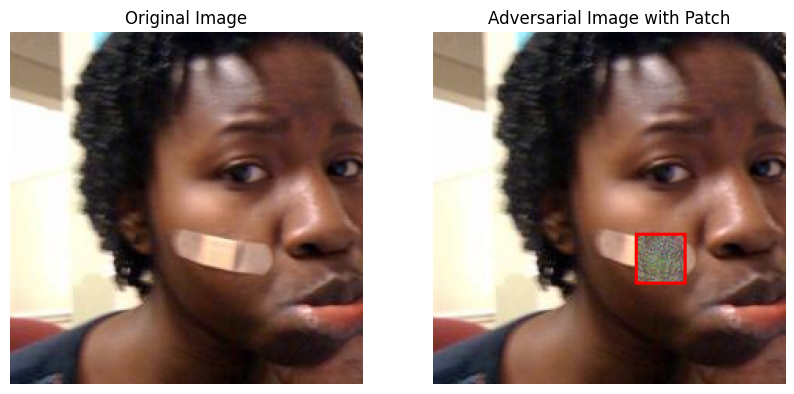

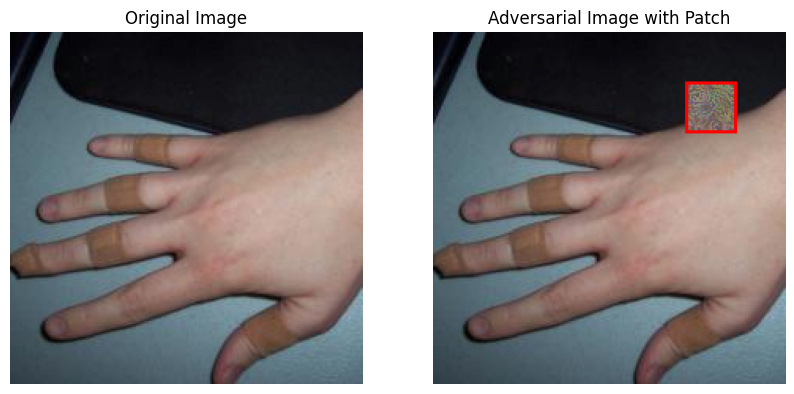

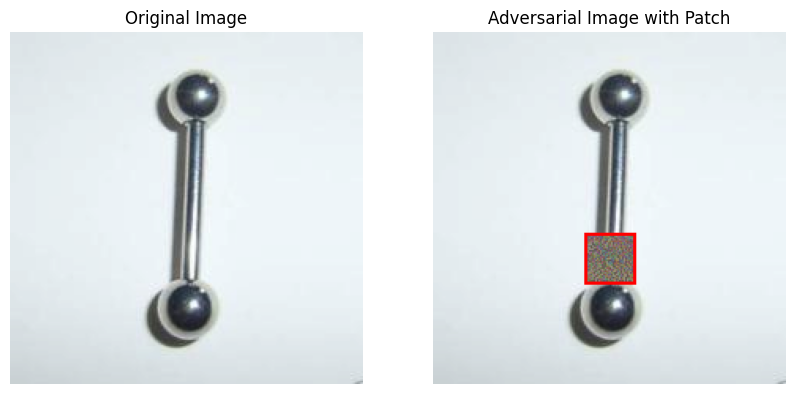

[Original] Top-1 Accuracy: 75.59%
[Original] Top-5 Accuracy: 93.87%
[Patch Attack] Top-1 Accuracy: 0.00%
[Patch Attack] Top-5 Accuracy: 31.25%
Top-1 Accuracy drop: 75.59%
Top-5 Accuracy drop: 62.62%


In [17]:
from PIL import Image, ImageDraw
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # 注册钩子
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
    
    def __call__(self, x, target_class):
        # 前向传播
        output = self.model(x)
        
        # 获取目标类别的得分
        target_score = output[0, target_class]
        
        # 反向传播
        self.model.zero_grad()
        target_score.backward()
        
        # 计算权重
        weights = torch.mean(self.gradients, dim=(2, 3))
        
        # 计算热力图
        cam = torch.zeros(self.activations.shape[2:], dtype=torch.float32, device=x.device)
        for i, w in enumerate(weights[0]):
            cam += w * self.activations[0, i, :, :]
        
        cam = F.relu(cam)  # ReLU激活
        cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), 
                          size=x.shape[2:], 
                          mode='bilinear', 
                          align_corners=False)
        # 修复：先detach再转换为numpy
        cam = cam.squeeze().detach().cpu().numpy()
        
        # 归一化
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-7)
        
        return cam

def pgd_patch_attack_targeted(image, label, model, epsilon, alpha, num_steps, patch_size, target_class):
    image = image.clone().detach().to(device)
    original_image = image.clone().detach()
    _, height, width = image.squeeze(0).shape
    
    # 使用Grad-CAM选择patch位置
    target_layer = model.layer4[-1]  # ResNet34的最后一个卷积层
    gradcam = GradCAM(model, target_layer)
    cam = gradcam(image, target_class)
    
    # 根据Grad-CAM选择最佳patch位置
    # 将热力图分成网格，每个网格大小为patch_size
    grid_h = (height - patch_size) // patch_size
    grid_w = (width - patch_size) // patch_size
    
    # 计算每个网格的平均激活值
    grid_activations = np.zeros((grid_h, grid_w))
    for i in range(grid_h):
        for j in range(grid_w):
            y_start = i * patch_size
            x_start = j * patch_size
            grid_activations[i, j] = cam[y_start:y_start+patch_size, 
                                       x_start:x_start+patch_size].mean()
    
    # 选择激活值最高的位置
    best_idx = np.argmax(grid_activations)
    best_i = best_idx // grid_w
    best_j = best_idx % grid_w
    top_left_y = best_i * patch_size
    top_left_x = best_j * patch_size
    
    # 初始化patch
    patch = torch.rand_like(image[:, :, top_left_y:top_left_y+patch_size, 
                                top_left_x:top_left_x+patch_size]) * 2 * epsilon - epsilon

    # 迭代优化
    for _ in range(num_steps):
        image.requires_grad_(True)
        output = model(image)
        target_logit = output[0, target_class.item()]
        max_other_logit = output[0, [i for i in range(1000) if i != target_class.item()]].max()
        loss = - (target_logit - max_other_logit)
        
        model.zero_grad()
        loss.backward()
        grad = image.grad.data
        
        with torch.no_grad():
            # 更新patch
            patch = patch - alpha * grad[:, :, top_left_y:top_left_y+patch_size, 
                                       top_left_x:top_left_x+patch_size].sign()
            patch = torch.clamp(patch, -epsilon, epsilon)
            
            # 重建图像
            image = original_image.clone()
            image[:, :, top_left_y:top_left_y+patch_size, top_left_x:top_left_x+patch_size] = patch
    
    return image.detach(), (top_left_x, top_left_y)

def pgd_patch_attack_best_targeted(image, label, model, epsilon, alpha, num_steps, patch_size, target_class, try_times=5):
    best_img = None
    best_patch_pos = None
    min_orig_rank = -1
    orig_class = label.item()
    
    for _ in range(try_times):
        adv_img, patch_pos = pgd_patch_attack_targeted(
            image, label, model, epsilon, alpha, num_steps, patch_size, target_class
        )
        
        with torch.no_grad():
            output = model(adv_img)
            sorted_logits = output.argsort(dim=1, descending=True)
            orig_rank = (sorted_logits == orig_class).nonzero(as_tuple=True)[1].item()
            
            if min_orig_rank == -1 or orig_rank > min_orig_rank:
                min_orig_rank = orig_rank
                best_img = adv_img
                best_patch_pos = patch_pos
            
            if orig_rank >= 5:  # 原始类别不在Top-5，直接返回
                return adv_img, patch_pos
    
    return best_img, best_patch_pos

# 主循环
adv_dataset_3 = []
patch_positions = []
orig_indices = []
pretrained_model.eval()
total_needed = 500
generated = 0

# 设置攻击参数
epsilon = 0.5  # 增加扰动范围
alpha = 0.1
num_steps = 20
patch_size = 32  # 保持32x32的patch大小
try_times = 5

for batch_idx, (images, labels) in enumerate(tqdm(dataloader, desc="Generating Patch adversarial examples (targeted+best patch)")):
    images = images.to(device)
    imagenet_labels = torch.tensor([idx_to_imagenet_idx[label.item()] for label in labels]).to(device)
    
    for i in range(images.size(0)):
        if generated >= total_needed:
            break
            
        img = images[i:i+1]
        label = imagenet_labels[i:i+1]
        orig_idx = batch_idx * dataloader.batch_size + i
        
        # 随机选择目标类别
        target_class = random.randint(0, 999)
        while target_class == label.item():
            target_class = random.randint(0, 999)
        target_class_tensor = torch.tensor([target_class]).to(device)
        
        # 使用Grad-CAM引导的patch攻击
        adv_img, patch_pos = pgd_patch_attack_best_targeted(
            img, label, pretrained_model, epsilon, alpha, num_steps, patch_size, 
            target_class_tensor, try_times=try_times
        )
        
        # 验证攻击效果
        with torch.no_grad():
            output = pretrained_model(adv_img)
            pred = output.argmax(dim=1)
            if pred.item() == target_class:  # 只有攻击成功才保存
                adv_dataset_3.append((adv_img.squeeze(0).cpu(), label.item(), orig_idx))
                patch_positions.append(patch_pos)
                orig_indices.append(orig_idx)
                generated += 1
    
    if generated >= total_needed:
        break

# 可视化几个示例
def visualize_examples(adv_dataset, patch_positions, num_examples=5):
    for i in range(min(num_examples, len(adv_dataset))):
        adv_img, label, orig_idx = adv_dataset[i]
        patch_pos = patch_positions[i]
        
        # 获取原始图像
        orig_img, _ = dataset[orig_idx]
        
        # 转换为PIL图像
        adv_img_np = inv_transform(adv_img).numpy().transpose(1, 2, 0)
        adv_img_np = np.clip(adv_img_np, 0, 1)
        adv_img_pil = Image.fromarray((adv_img_np * 255).astype(np.uint8))
        
        orig_img_np = inv_transform(orig_img).numpy().transpose(1, 2, 0)
        orig_img_np = np.clip(orig_img_np, 0, 1)
        orig_img_pil = Image.fromarray((orig_img_np * 255).astype(np.uint8))
        
        # 在图像上标记patch位置
        adv_img_draw = adv_img_pil.copy()
        draw = ImageDraw.Draw(adv_img_draw)
        x, y = patch_pos
        draw.rectangle([x, y, x+patch_size, y+patch_size], outline='red', width=2)
        
        # 显示图像
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(orig_img_pil)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(adv_img_draw)
        plt.title('Adversarial Image with Patch')
        plt.axis('off')
        
        plt.show()

# 可视化示例
visualize_examples(adv_dataset_3, patch_positions)

# 评估模型性能
top1_correct = 0
top5_correct = 0
total = 0
pretrained_model.eval()

with torch.no_grad():
    for i in range(0, len(adv_dataset_3), 32):
        batch = adv_dataset_3[i:i+32]
        images = torch.stack([img for img, _, _ in batch]).to(device)
        labels = torch.tensor([lbl for _, lbl, _ in batch]).to(device)
        outputs = pretrained_model(images)
        top1_correct += compute_topk_accuracy(outputs, labels, k=1)
        top5_correct += compute_topk_accuracy(outputs, labels, k=5)
        total += len(images)

top1_t4_accuracy = 100. * top1_correct / total
top5_t4_accuracy = 100. * top5_correct / total

print(f"[Original] Top-1 Accuracy: {top1_t1_accuracy:.2f}%")
print(f"[Original] Top-5 Accuracy: {top5_t1_accuracy:.2f}%")
print(f"[Patch Attack] Top-1 Accuracy: {top1_t4_accuracy:.2f}%")
print(f"[Patch Attack] Top-5 Accuracy: {top5_t4_accuracy:.2f}%")
print(f"Top-1 Accuracy drop: {(top1_t1_accuracy - top1_t4_accuracy):.2f}%")
print(f"Top-5 Accuracy drop: {(top5_t1_accuracy - top5_t4_accuracy):.2f}%")